__Testing b_star and its connection with phase transitions__

Ingnore code, read comments under the pictures. Some plot names does not correspond to an underlying graph, consult the text under the plot. 

In [1]:
import sys
sys.path.append("..")
from multiprocessing import Pool
import numpy as np
from graph import Circle, Grid, RandomRegular, GraphByDegrees, ErdosRenyi, ScaleFree
from b_star import get_b_stars, get_b_stars_single
from viz import draw_data
from utils import Timer, partition
from engine import fun
from engine_mono import fun_mono
from engine_sum import fun_sum
from engine_single import fun_single
from graph_toolset import coreness
import jupyternotify
import random
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>

In [2]:
def total(graph, keys):
    if 'total' in keys:
        return {'total': graph.nodes}
    else:
        return {}

In [3]:
def calc(fun_name, alphas, bs, graphs, T, init_type='01', set_builder=total, keys=['total'], pool_size=32):
    pool = Pool(pool_size)
    
    res = dict()
    for key in keys:
        res[key] = []

    timer = Timer()
    
    now = 0
    
    for graph in graphs:
        local_timer = Timer()
        
        sets = set_builder(graph, keys)
        
        points = [(graph, b, alpha, T, init_type, sets) for alpha in alphas for b in bs]
        
        if fun_name == 'fun':
            cur = pool.map(fun, points)
        elif fun_name == 'mono':
            cur = pool.map(fun_mono, points)
        elif fun_name == 'sum':
            cur = pool.map(fun_sum, points)
        elif fun_name == 'single':
            cur = pool.map(fun_single, points)
        else:
            raise Exception(f'dont know fun name {fun_name}!')
        
        for key in keys:
            tmp = []
            for step in cur:
                tmp.append(step[key])
            
            tmp = np.array(tmp)
            tmp = np.reshape(tmp, (len(alphas), len(bs), tmp.shape[1]))
            res[key].append(tmp)
        
        t = local_timer.measure()
        now += 1
        rem = len(graphs) - now
        print(f'#{now} passed in {local_timer.measure()},  projected end in {timer.measure() / now * rem / 60} minutes', flush=True)
        
    for key in keys:
        res[key] = np.array(res[key])
        
    timer.print_elapsed()
    
    return res

In [4]:
def cut_alpha(data, alpha_id=0):
    res = dict()
    for key, arr in data.items():
        res[key] = arr[:, alpha_id, :, :]
    return res

In [5]:
def plot_means(ax, bs, data, last, keys, title, show_data=True):
    for key in keys:
        cur = np.apply_along_axis(np.mean, 2, data[key][:, :, -last:])
        if show_data:
            for t in cur:
                ax.scatter(bs, t, s=1, alpha=.05)

        cur = np.apply_along_axis(np.mean, 0, cur)
        ax.plot(bs, cur, '-', label=f'{key}')
    ax.legend()
    ax.set_title(title)

In [6]:
def plot_individual(data, prob, keys, title):
    fig, ax = plt.subplots()
    
    for key in keys:
        for i in range(data[key].shape[0]):
            for j in range(data[key].shape[1]):
                for k in range(data[key].shape[2]):
                    if random.uniform(0, 1) < prob:
                        ax.plot(data[key][i][j][k])
    ax.set_title(title)
    plt.show()

In [7]:
def get_er(_):
    return ErdosRenyi(1000, 4. / 1000.)

graphs_er = Pool(32).map(get_er, [() for _ in range(500)])

In [8]:
def degs(graph, keys=[]):
    sets = dict()
    for key in keys:
        sets[key] = []
    
    for v in graph.nodes:
        d = graph.deg(v)
        if d not in keys:
            continue
        sets[d].append(v)
    return sets

In [9]:
def plot_ratios(ax, graph, scale=1, bins=100, single=False):
    if single:
        ratios = get_b_stars_single(graph)
    else:
        ratios = get_b_stars(graph)
    ratios = {k: v for k, v in ratios.items() if 1 < k <= 10}
    total = sum(ratios.values())
    ratios = {k: v / total * scale for k, v in ratios.items()}
    ax.hist(list(ratios.keys()), weights=list(ratios.values()), bins=bins)

In [10]:
def plot_ratios_and_means(res, graph, scale=2, bins=100, single=False, name='-'):
    fig, ax = plt.subplots() 
    plot_means(ax, partition(0, 10, 256), cut_alpha(res), 200, ['total'], name, show_data=False)
    plot_ratios(ax, graph, scale=scale, bins=bins, single=single)
    plt.show()

In [24]:
res = calc('fun', [.1], partition(0, 10, 256), graphs_er[0:1]*10, 200, set_builder=total, keys=['total'])

#1 passed in 45.98750400543213,  projected end in 6.898131394386292 minutes
#2 passed in 46.2032630443573,  projected end in 6.146190404891968 minutes
#3 passed in 47.017863512039185,  projected end in 5.413801933659448 minutes
#4 passed in 46.452932834625244,  projected end in 4.641650468111038 minutes
#5 passed in 46.508835554122925,  projected end in 3.869596735636393 minutes
#6 passed in 45.58975410461426,  projected end in 3.0862939569685195 minutes
#7 passed in 45.54998207092285,  projected end in 2.309409495762416 minutes
#8 passed in 46.09189224243164,  projected end in 1.5392096092303593 minutes
#9 passed in 46.7619833946228,  projected end in 0.7706912159919739 minutes
#10 passed in 46.031532764434814,  projected end in 0.0 minutes
time elapsed = 462.20946741104126


__One strategy per edge model__  
Average cooperation rate for a __single__ graph is plotted over 20 runs.   
Under the cooperation rate, histogram of frequencies b* is plotted. b* are filtered to lie in (1, 10] semi-interval.

<IPython.core.display.Javascript object>


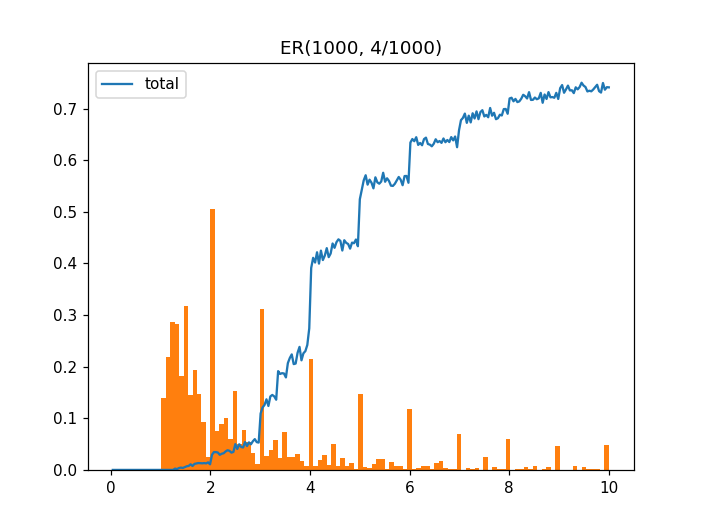

In [35]:
fig, ax = plt.subplots() 
plot_means(ax, partition(0, 10, 256), cut_alpha(res), 20, ['total'], 'ER(1000, 4/1000)', show_data=False)
plot_ratios(ax, graphs_er[0], scale=5)
plt.show()

On the plot above, we can see that in Erods-Renyi model, phase transitions are indeed correlate with frequency of b*.

In [26]:
graph23 = GraphByDegrees({2: 500, 3: 500})
res23 = calc('fun', [.1], partition(0, 10, 256), [graph23]*10, 1000, set_builder=total, keys=['total'])

#1 passed in 199.88788747787476,  projected end in 29.98318930864334 minutes
#2 passed in 200.32898426055908,  projected end in 26.681303628285725 minutes
#3 passed in 202.66911697387695,  projected end in 23.445755966504414 minutes
#4 passed in 199.5582730770111,  projected end in 20.06125938296318 minutes
#5 passed in 199.1129069328308,  projected end in 16.692740682760874 minutes
#6 passed in 197.8845853805542,  projected end in 13.327223398950364 minutes
#7 passed in 198.65969109535217,  projected end in 9.986510629313333 minutes
#8 passed in 199.5808334350586,  projected end in 6.657064193487168 minutes
#9 passed in 199.55962586402893,  projected end in 3.328252473583928 minutes
#10 passed in 198.30047082901,  projected end in 0.0 minutes
time elapsed = 1995.573885679245


<IPython.core.display.Javascript object>


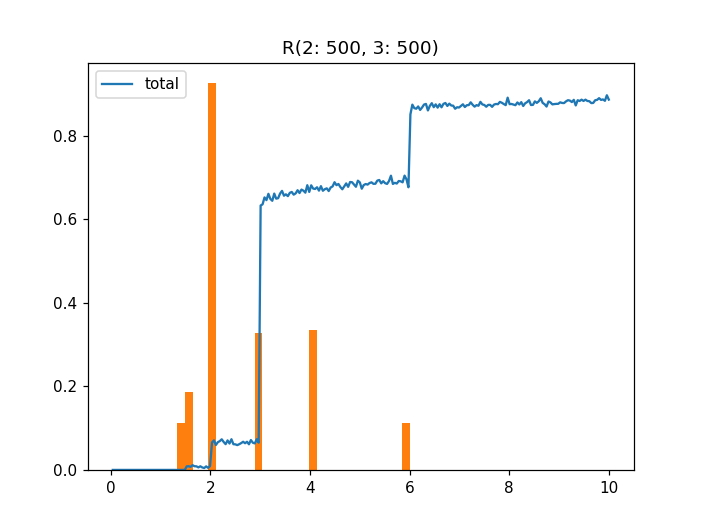

In [31]:
fig, ax = plt.subplots() 
plot_means(ax, partition(0, 10, 256), cut_alpha(res23), 200, ['total'], 'R(2: 500, 3: 500)', show_data=False)
plot_ratios(ax, graph23, scale=2, bins=30, adjusted=True)
plt.show()

As we can see, if there is a phase transition, there are always concentration of b*. Inverse is not true.

In [13]:
graph3 = GraphByDegrees({3: 100})
graph5 = GraphByDegrees({5: 100})
graph35 = GraphByDegrees({3: 200, 5: 200})

In [ ]:
res3 = calc('fun', [.1], partition(0, 10, 256), [graph3]*10, 1000, set_builder=total, keys=['total'])
res35 = calc('fun', [.1], partition(0, 10, 256), [graph35]*10, 1000, set_builder=total, keys=['total'])

In [16]:
res5 = calc('single', [.1], partition(0, 10, 256), [graph5]*10, 1000, set_builder=total, keys=['total'])

#1 passed in 19.20663809776306,  projected end in 2.8810008645057676 minutes
#2 passed in 19.182102918624878,  projected end in 2.559402863184611 minutes
#3 passed in 19.19925093650818,  projected end in 2.239653480052948 minutes
#4 passed in 19.231919288635254,  projected end in 1.9205969870090485 minutes
#5 passed in 19.250062465667725,  projected end in 1.601246976852417 minutes
#6 passed in 19.171902179718018,  projected end in 1.2805278645621407 minutes
#7 passed in 19.20198655128479,  projected end in 0.9603591595377241 minutes
#8 passed in 19.157509803771973,  projected end in 0.6400357216596604 minutes
#9 passed in 19.194751024246216,  projected end in 0.32000756131278146 minutes
#10 passed in 19.176690340042114,  projected end in 0.0 minutes
time elapsed = 191.99109053611755


<IPython.core.display.Javascript object>


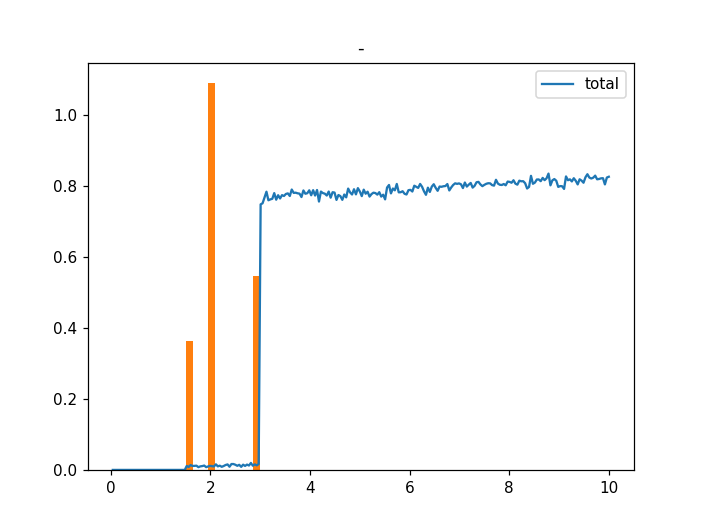

In [27]:
plot_ratios_and_means(res3, graph3, bins=10)

Regular graph with degree 3.

<IPython.core.display.Javascript object>


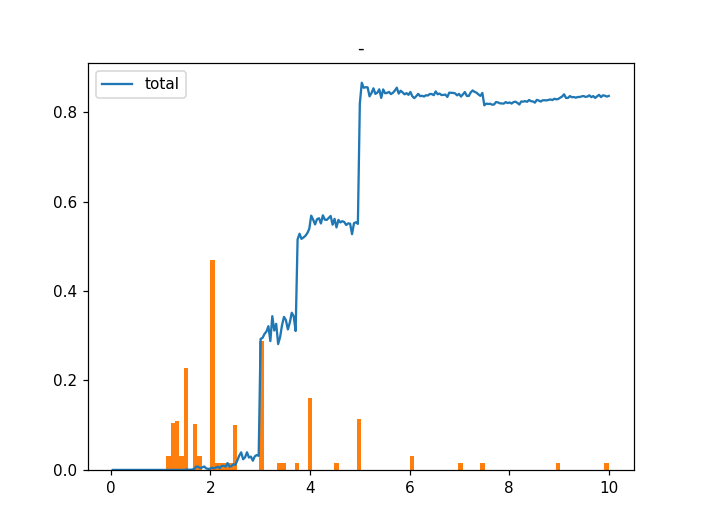

In [29]:
plot_ratios_and_means(res35, graph35, bins=100)

Graph with degrees 3 and 5.

__Single strategy pre node__

<IPython.core.display.Javascript object>


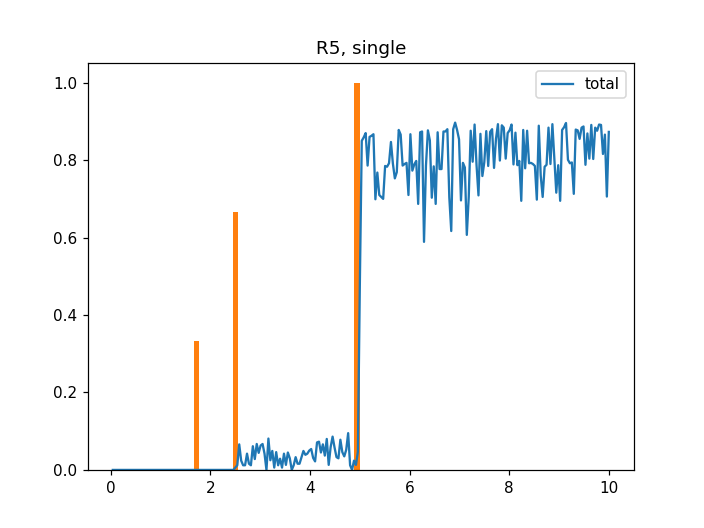

In [21]:
plot_ratios_and_means(res5, graph5, bins=30, single=True, name='R5, single')

Regular graph with degrees 5. Note that here are actually two phase transitions are present.

In [22]:
res3s = calc('single', [.1], partition(0, 10, 256), [graph3]*10, 1000, set_builder=total, keys=['total'])

#1 passed in 15.16987919807434,  projected end in 2.2754875302314757 minutes
#2 passed in 15.191484689712524,  projected end in 2.024219099680583 minutes
#3 passed in 15.221992492675781,  projected end in 1.7727909551726446 minutes
#4 passed in 15.250665187835693,  projected end in 1.5209415555000305 minutes
#5 passed in 15.165459156036377,  projected end in 1.26672975619634 minutes
#6 passed in 15.164597749710083,  projected end in 1.0129928615358141 minutes
#7 passed in 15.160859823226929,  projected end in 0.7595103791781833 minutes
#8 passed in 15.204447507858276,  projected end in 0.5064041624466579 minutes
#9 passed in 15.198622703552246,  projected end in 0.25321552841751666 minutes
#10 passed in 15.229858636856079,  projected end in 0.0 minutes
time elapsed = 151.9768168926239


In [23]:
res35s = calc('single', [.1], partition(0, 10, 256), [graph35]*10, 1000, set_builder=total, keys=['total'])

#1 passed in 68.6820375919342,  projected end in 10.30231032371521 minutes
#2 passed in 68.83506965637207,  projected end in 9.16794581413269 minutes
#3 passed in 68.86754441261292,  projected end in 8.026183802551694 minutes
#4 passed in 68.65246534347534,  projected end in 6.876026034355164 minutes
#5 passed in 68.86467790603638,  projected end in 5.731775351365408 minutes
#6 passed in 68.84433484077454,  projected end in 4.586131437619527 minutes
#7 passed in 68.7394859790802,  projected end in 3.4392295479774475 minutes
#8 passed in 68.61582398414612,  projected end in 2.292120466629664 minutes
#9 passed in 68.6710593700409,  projected end in 1.1458934647065624 minutes
#10 passed in 68.79942679405212,  projected end in 0.0 minutes
time elapsed = 687.5931353569031


<IPython.core.display.Javascript object>


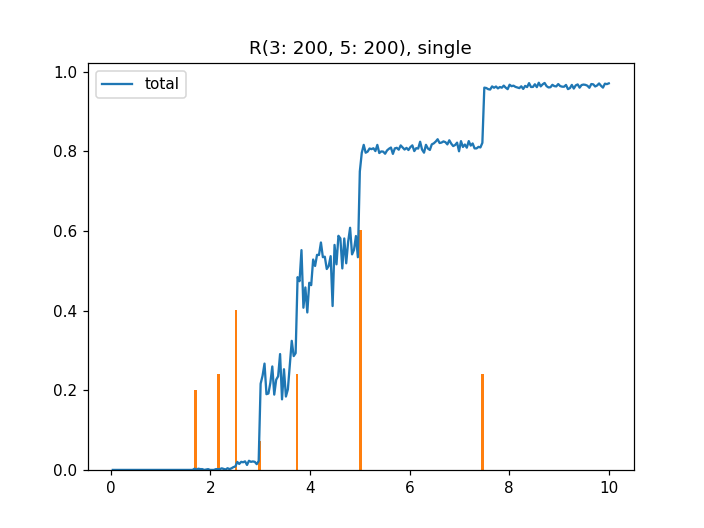

In [24]:
plot_ratios_and_means(res35s, graph35, bins=100, single=True, name='R(3: 200, 5: 200), single')

Graph R(3: 500, 5: 500), single strategy per node.

<IPython.core.display.Javascript object>


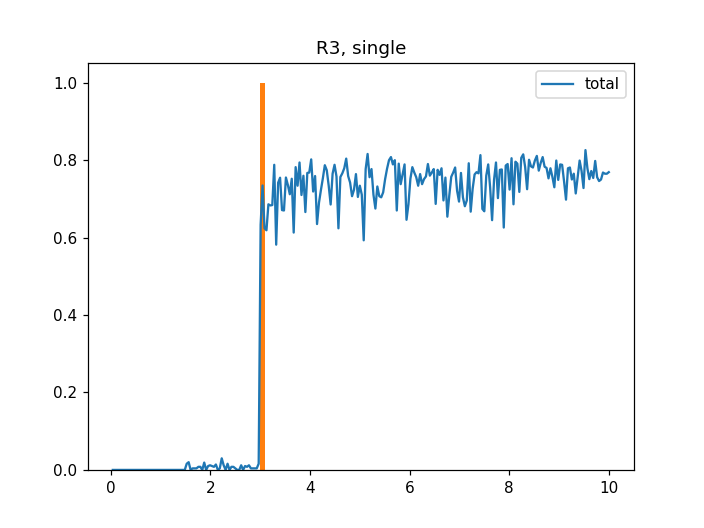

In [27]:
plot_ratios_and_means(res3s, graph3, bins=10, scale=1, single=True, name='R3, single')

3-regular graph, single strategy per node. Some noise on segment [1.5, 3] is hopefully due to small number of iteration.

In [12]:
graphER = ErdosRenyi(1000, 4 / 1000)
resERs = calc('single', [.1], partition(0, 10, 256), [graphER]*10, 1000, set_builder=total, keys=['total'])

#1 passed in 186.7068383693695,  projected end in 28.006030654907228 minutes
#2 passed in 186.0032558441162,  projected end in 24.847552331288657 minutes
#3 passed in 185.6312382221222,  projected end in 21.71344589259889 minutes
#4 passed in 186.4288260936737,  projected end in 18.61939782500267 minutes
#5 passed in 185.2986400127411,  projected end in 15.501258532206217 minutes
#6 passed in 185.95439314842224,  projected end in 12.400345447328355 minutes
#7 passed in 185.88544344902039,  projected end in 9.299413604395731 minutes
#8 passed in 186.02127718925476,  projected end in 6.199754484494528 minutes
#9 passed in 184.66181802749634,  projected end in 3.097414803504944 minutes
#10 passed in 184.43074822425842,  projected end in 0.0 minutes
time elapsed = 1857.0498533248901


<IPython.core.display.Javascript object>


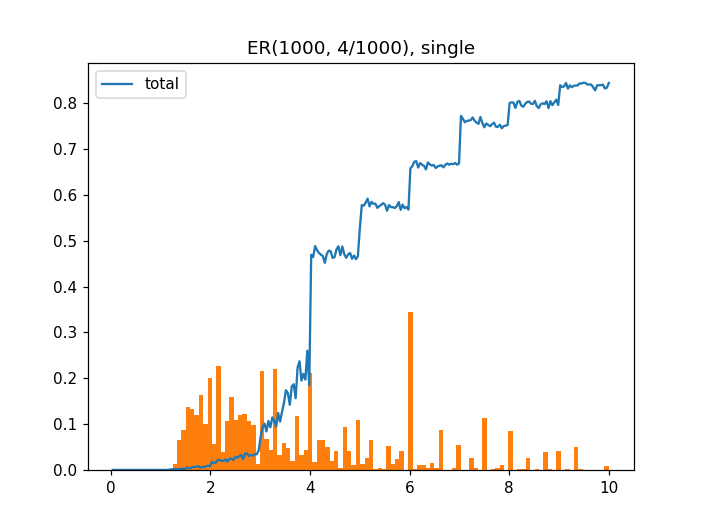

In [13]:
plot_ratios_and_means(resERs, graphER, bins=100, scale=5, single=True, name='ER(1000, 4/1000), single')

Erdos-Renyi graph, single strategy per node.

In [14]:
graphSF = ScaleFree(100, 3)

In [15]:
resSFs = calc('single', [.1], partition(0, 10, 256), [graphSF]*200, 1000, set_builder=total, keys=['total'])

#1 passed in 21.555874586105347,  projected end in 71.49374876419704 minutes
#2 passed in 21.721400499343872,  projected end in 71.41115219593048 minutes
#3 passed in 21.821985960006714,  projected end in 71.25097990168466 minutes
#4 passed in 21.644399881362915,  projected end in 70.84396607875824 minutes
#5 passed in 21.728859186172485,  projected end in 70.51038520336151 minutes
#6 passed in 21.77730655670166,  projected end in 70.19341991212632 minutes
#7 passed in 21.65382742881775,  projected end in 69.80661669628961 minutes
#8 passed in 21.774590253829956,  projected end in 69.47447032928467 minutes
#9 passed in 21.726067066192627,  projected end in 69.11832642952601 minutes
#10 passed in 21.679161071777344,  projected end in 68.74616473913193 minutes
#11 passed in 21.641278743743896,  projected end in 68.36511131741783 minutes
#12 passed in 21.735753059387207,  projected end in 68.01212477419112 minutes
#13 passed in 21.63595151901245,  projected end in 67.63383675477444 minute

#107 passed in 21.747967004776,  projected end in 33.66744626493097 minutes
#108 passed in 21.8074951171875,  projected end in 33.30667388424461 minutes
#109 passed in 21.732062101364136,  projected end in 32.94480165228567 minutes
#110 passed in 21.64358615875244,  projected end in 32.58171599344774 minutes
#111 passed in 21.912819385528564,  projected end in 32.22227147817612 minutes
#112 passed in 21.67612624168396,  projected end in 31.859625620785213 minutes
#113 passed in 21.694885969161987,  projected end in 31.497245752389453 minutes
#114 passed in 21.714317083358765,  projected end in 31.135125998377102 minutes
#115 passed in 21.71588373184204,  projected end in 30.773025462420094 minutes
#116 passed in 21.630356788635254,  projected end in 30.40989403395817 minutes
#117 passed in 21.766210794448853,  projected end in 30.048412481739987 minutes
#118 passed in 21.627867460250854,  projected end in 29.685314972319848 minutes
#119 passed in 21.646766662597656,  projected end in 2

<IPython.core.display.Javascript object>


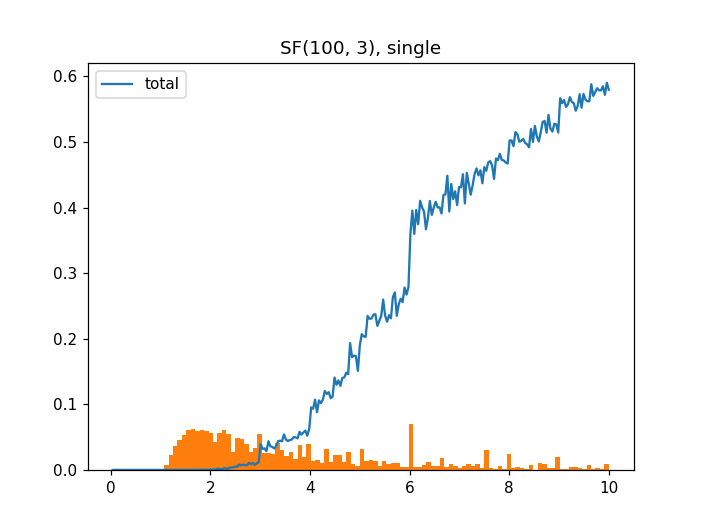

In [16]:
plot_ratios_and_means(resSFs, graphSF, single=True, name='SF(100, 3), single')

Scale-Free graph. Scale-Free graph require a lot of iterations to converge and exhibit large variation. This may be due to large variation in scale free graph degrees.  
However, large jump in b=6 is clearly visible.